# Deep Q-Networks
Use neural networks to directly estimate Q-values of state-action pairs. Computationally expensive, hyperparameter sensitive, very powerful.

In [1]:
import gym
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
import random
from FA.visual import reward_visual
from collections import deque

In [5]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# GPU not used since we are working with single values (not arrays eg. images)

In [2]:
class DQN():
    def __init__(self, num_states, num_actions, num_hidden=50, lr=0.05):
        self.criterion = nn.MSELoss()
        self.model = nn.Sequential(nn.Linear(num_states, num_hidden), 
                                   nn.ReLU(), nn.Linear(num_hidden, num_actions))
        self.optim = Adam(self.model.parameters(), lr)
    
    def update(self, state, y):
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, torch.Tensor(y))
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()

    def predict(self, state):
        with torch.no_grad():
            return self.model(torch.Tensor(state))

    def replay(self, memory, replay_size, gamma):
        # Experience replay to improve learning
        if len(memory) >= replay_size: 
            replay_data = random.sample(memory, replay_size)
            states, td_targets = [], []
            for state, action, next_state, reward, is_done in replay_data:
                states.append(state)
                q_values = self.predict(state).numpy()
                if is_done:
                    q_values[action] = reward
                else:
                    # Q-Learning
                    q_values_next = self.predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()
                td_targets.append(q_values)
            self.update(states, td_targets)

In [3]:
env = gym.make("MountainCar-v0")
num_states, num_actions = env.observation_space.shape[0], env.action_space.n

In [4]:
def gen_eps_greedy_policy(estimator, eps, num_actions):
    def policy(state):
        if random.random() < eps:
            return random.randint(0, num_actions - 1)
        else:
            q_values = estimator.predict(state)
            return torch.argmax(q_values).item()
    return policy

In [5]:
def q_learning(env, estimator, num_episodes, gamma=1, epsilon=0.1, eps_decay=0.99):
    total_reward_episode = [0] * num_episodes
    num_actions = env.action_space.n
    for episode in tqdm(range(num_episodes)):
        policy = gen_eps_greedy_policy(estimator, epsilon, num_actions)
        state = env.reset()
        is_done = False

        while not is_done:
            action = policy(state)
            next_state, reward, is_done, _ = env.step(action)
            total_reward_episode[episode] += reward
            # Modified updates: promotes exploration, problem specific implementation. 
            # Not part of the DQN model
            modified_reward = state[0] + 0.5
            if next_state[0] >= 0.5:
                modified_reward += 100
            elif next_state[0] >= 0.25:
                modified_reward += 20
            elif next_state[0] >= 0.1:
                modified_reward += 10
            elif next_state[0] >= 0:
                modified_reward += 5

            if is_done:
                q_values[action] = modified_reward
                estimator.update(state, q_values)
                break
            q_values = estimator.predict(next_state).numpy()
            q_values_next = estimator.predict(next_state)
            q_values[action] = modified_reward + gamma * torch.max(q_values_next).item()
            estimator.update(state, q_values)
            state = next_state

        epsilon = max(epsilon * eps_decay, 0.01)
    return total_reward_episode

In [33]:
estimator = DQN(num_states, num_actions, num_hidden=50, lr=0.001)
num_episodes = 1000

# VERY HYPERPARAMETER DEPENDENT
total_reward_episode = q_learning(env, estimator, num_episodes, gamma=0.99, epsilon=0.3)

100%|██████████| 1000/1000 [04:12<00:00,  3.96it/s]


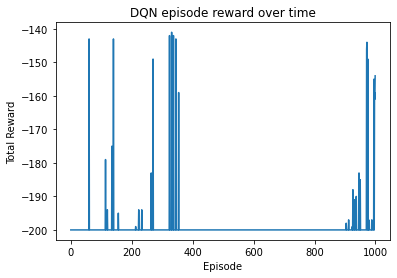

In [34]:
reward_visual(total_reward_episode, "DQN episode reward over time")

In [35]:
print(sum(total_reward_episode))

-199068.0


## Experience Replay
Update the Q-network with a randomized minibatch of states at each time step instead of sequential states. Increases learning efficiency.

In [6]:


def exp_q_learning(env, estimator, num_episodes, replay_size, gamma=1.0, 
                   epsilon=0.1, eps_decay=0.99, memory_size=10000):
    memory = deque(maxlen=memory_size)
    total_reward_episode = [0] * num_episodes
    for episode in tqdm(range(num_episodes)):
        policy = gen_eps_greedy_policy(estimator, epsilon, num_actions)
        state = env.reset()
        is_done = False

        while not is_done:
            action = policy(state)
            next_state, reward, is_done, _ = env.step(action)
            total_reward_episode[episode] += reward
            # Modified updates: promotes exploration, problem specific implementation. 
            # Not part of the DQN model
            modified_reward = state[0] + 0.5
            if next_state[0] >= 0.5:
                modified_reward += 100
            elif next_state[0] >= 0.25:
                modified_reward += 20
            elif next_state[0] >= 0.1:
                modified_reward += 10
            elif next_state[0] >= 0:
                modified_reward += 5
            memory.append((state, action, next_state, modified_reward, is_done))
            state = next_state
            estimator.replay(memory, replay_size, gamma)
        epsilon = max(epsilon * eps_decay, 0.1)
    return total_reward_episode

In [56]:
estimator = DQN(num_states, num_actions, num_hidden=50, lr=0.001)

num_episodes = 600
replay_size = 20
total_reward_episode = exp_q_learning(env, estimator, num_episodes, replay_size, gamma=0.9, epsilon=0.3)

100%|██████████| 600/600 [12:54<00:00,  1.29s/it]


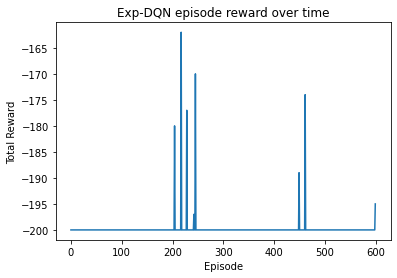

In [57]:
reward_visual(total_reward_episode, "Exp-DQN episode reward over time")

## Double DQN
Using two DQNs instead of 1. The first DQN is used as the target network which predicts the Q-value for the next state. This network has a similar structure to the prediction network, but is updated once every `target_update` episodes. This means this network is a number of episodes in the past compared to the prediction network at all times. The prediction network is the one that estimates the Q-values for the current state and is updated at each time step. This network is copied into the target network at regular intervals.

In [7]:
import copy

In [8]:
class DoubleDQN(DQN):
    # Use different models for the state and next_state Q-value predictions
    # Update the next_state Q-value model every target_update episodes
    def __init__(self, num_states, num_actions, num_hidden, lr):
        super().__init__(num_states, num_actions, num_hidden=num_hidden, lr=lr)
        self.model_target = copy.deepcopy(self.model)
        
    def target_predict(self, state):
        with torch.no_grad():
            return self.model_target(torch.Tensor(state))
    
    def copy_target(self):
        self.model_target.load_state_dict(self.model.state_dict())
    
    def replay(self, memory, replay_size, gamma):
        if len(memory) >= replay_size: 
            replay_data = random.sample(memory, replay_size)
            states, td_targets = [], []
            for state, action, next_state, reward, is_done in replay_data:
                states.append(state)
                q_values = self.predict(state).numpy()
                if is_done:
                    q_values[action] = reward
                else:
                    # Q-Learning
                    q_values_next = self.target_predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()
                td_targets.append(q_values)
            self.update(states, td_targets)

In [14]:
def double_q_learning(env, estimator, num_episodes, replay_size, target_update=10, 
                      gamma=1.0, epsilon=0.1, eps_decay=0.99, memory_size=10000):
    memory = deque(maxlen=memory_size)
    total_reward_episode = [0] * num_episodes
    for episode in tqdm(range(num_episodes)):
        if episode % target_update == 0:
            estimator.copy_target()
        policy = gen_eps_greedy_policy(estimator, epsilon, num_actions)
        state = env.reset()
        is_done = False

        while not is_done:
            action = policy(state)
            next_state, reward, is_done, _ = env.step(action)
            total_reward_episode[episode] += reward
            # Modified updates: promotes exploration, problem specific implementation. 
            # Not part of the DQN model
            modified_reward = state[0] + 0.5
            state_map = {0.5: 100, 0.25: 20, 0.1: 10, 0:5}
            for k, v in state_map.items():
                if next_state[0] >= k:
                    modified_reward += v
                    break
            memory.append((state, action, next_state, modified_reward, is_done))
            state = next_state
            estimator.replay(memory, replay_size, gamma)
        epsilon = max(epsilon * eps_decay, 0.01)
    return total_reward_episode

In [15]:
estimator = DoubleDQN(num_states, num_actions, num_hidden=50, lr=0.01)
num_episodes = 1000
replay_size = 20
target_update = 10
total_reward_episode = double_q_learning(env, estimator, num_episodes, replay_size,
                                         target_update, gamma=0.9, epsilon=1)

100%|██████████| 1000/1000 [18:43<00:00,  1.12s/it]


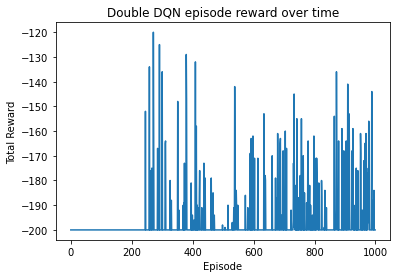

In [16]:
reward_visual(total_reward_episode, "Double DQN episode reward over time")

### Hyperparameter Tuning
Grid search across the hyperparameters to find the best set in the DQN. As we have now ventured into deep RL, hyperparameters are going to be a lot more significant. The `sklearn` library has great functions for this. 

In [9]:
def std_double_q_learning(env, estimator, num_episodes, replay_size, target_update=10, 
                         gamma=1, epsilon=0.1, epsilon_decay=0.99, memory_size=10000):
    memory = deque(maxlen=memory_size)
    total_reward_episode = [0] * num_episodes
    for episode in range(num_episodes):
        if episode % target_update == 0:
            estimator.copy_target()
        policy = gen_eps_greedy_policy(estimator, epsilon, env.action_space.n)
        state = env.reset()
        is_done = False
        while not is_done:
            action = policy(state)
            next_state, reward, is_done, _ = env.step()
            total_reward_episode[episode] += reward
            memory.append((state, action, next_state, reward, action))
            estimator.replay(memory, replay_size, gamma)
            state = next_state
        epsilon = max(epsilon * epsilon_decay, 0.01)
    return total_reward_episode

In [ ]:
num_episodes = 600
opt_dict = {"num_hidden": [30, 40, 50],
            "lr": [0.001, 0.002, 0.003],
            "replay_size": [20, 25],
            "target_update": [30, 35]}

for num_hidden in opt_dict["num_hidden"]:
    for lr in opt_dict["lr"]:
        for replay_size in opt_dict["replay_size"]:
            for target_update in opt_dict["target_update"]:
                # Set seeds 
                env.seed(1)
                random.seed(1)
                torch.manual_seed(1)
                dqn = DQN(num_states, num_actions, num_hidden, lr)
                total_reward_episode = std_double_q_learning(env, dqn, num_episodes, 
                                            replay_size, target_update, gamma=0.9, epsilon=1)
                print(num_hidden, lr, replay_size, target_update)
                # print the result of the last 200 episodes
                print(sum(total_reward_episode[num_episodes - 200:])/200)

# Best results: num_hidden=30, lr=0.001, replay_size=25, target_update=35

## Dueling DQNs
Use 2 functions to evaluate the Q-function. The state value function V, and the advantage function A. The advantage function is an estimator for action selection, choosing which action will be better at a state s.

In [10]:
class DuelingModel(nn.Module):
    def __init__(self, num_input, num_output, num_hidden):
        super(DuelingModel, self).__init__()
        # Advantange model
        self.adv_1 = nn.Linear(num_input, num_hidden)
        self.adv_2 = nn.Linear(num_hidden, num_output)
        # Value model
        self.val_1 = nn.Linear(num_input, num_hidden)
        self.val_2 =  nn.Linear(num_hidden, num_output)
        self.relu = nn.ReLU()

    def forward(self, x):
        adv = self.relu(self.adv_1(x))
        adv = self.adv_2(adv)

        val = self.relu(self.val_1(x))
        val = self.val_2(val)

        return val + adv - adv.mean()
    
class DDQN(DoubleDQN):
    def __init__(self, num_states, num_actions, num_hidden=50, lr=0.05):
        super().__init__(num_states, num_actions, num_hidden=num_hidden, lr=lr)
        self.model = DuelingModel(num_states, num_actions, num_hidden)
        self.criterion = nn.MSELoss()
        self.optim = Adam(self.model.parameters(), lr)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        self.model_target = copy.deepcopy(self.model)


In [40]:
num_hidden=50
lr=0.001
ddqn = DDQN(num_states, num_actions, num_hidden, lr)

In [41]:
num_episodes = 500
replay_size = 20
total_reward_episode = double_q_learning(env, ddqn, num_episodes, replay_size, gamma=0.9, epsilon=0.3)

100%|██████████| 500/500 [18:17<00:00,  2.19s/it]


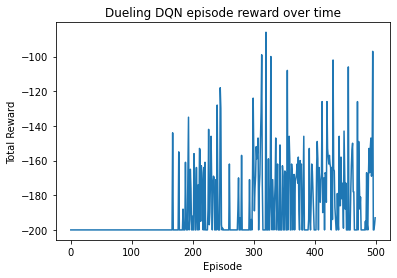

In [43]:
reward_visual(total_reward_episode, "Dueling DQN episode reward over time")

## Atari Pong
Using DQN's to play Pong -> A complex enough game for deep RL.

Pong, a.k.a. ping-pong or table tennis, is an old Atari 2600 game on a 210*160 RGB screen. The possible actions are:
- 0 - NOOP - The agent stays still
- 1, 4, 5 - FIRE - Meaningless
- 2 - RIGHT - The agent moves up
- 3 - LEFT - The agent moves down

Each action is repeated for *k* frames. The rewards are:
- -1 - The agent misses the ball
- +1 - The player misses the ball
- 0 otherwise

In [62]:
env = gym.make("PongDeterministic-v4")

In [63]:
state_shape = env.observation_space.shape
num_actions = env.action_space.n

print(env.unwrapped.get_action_meanings())
state_shape, num_actions

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


((210, 160, 3), 6)

In [89]:
ACTIONS = [0, 2, 3]  # The other actions are useless
num_actions = 3

In [15]:
env.reset()
is_done = False
env.render()
import time
while not is_done:
    action = ACTIONS[random.randint(0, num_actions - 1)]
    state, reward, is_done, _ = env.step(action)
    # print(reward, is_done)
# print(state)

In [16]:
env.close()


In [65]:
# Transform 210*160*3 RGB image to grayscale

import torchvision.transforms as transforms
from PIL import Image


In [66]:
img_size = 84
transform = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(), 
                               transforms.Resize((img_size, img_size), 
                               interpolation=transforms.InterpolationMode.BICUBIC),
                               transforms.ToTensor()])

def get_state(img):
    state = img.transpose((2, 0, 1))
    state = torch.from_numpy(state)
    state = transform(state)
    return state

In [67]:
print(state.shape)

(210, 160, 3)


In [68]:
get_state(state).shape

torch.Size([1, 84, 84])

In [69]:
# Deep Q-Network model for image data
class FCImageDQN(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dims):
        super(FCImageDQN, self).__init__()
        self.relu = nn.ReLU()
        self.fc_1 = nn.Linear(in_dim, hidden_dims[0])
        self.fc_2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc_3 = nn.Linear(hidden_dims[1], out_dim)
    
    def forward(self, x):
        x = self.relu(self.fc_1(x))
        x = self.relu(self.fc_2(x))
        return self.fc_3(x)

# Refactored the Double DQN model code to now allow image models to be passed directly
class DoubleDQNImage(DoubleDQN):
    def __init__(self, num_states, num_actions, num_hidden, lr=0.05, model=FCImageDQN):
        # Num hidden in super() set to 1 to prevent errors.
        # Previous method was written with 1 hidden layer in mind.
        super().__init__(num_states, num_actions, 1, lr=lr)
        self.model = model(num_states, num_actions, num_hidden)
        self.criterion = nn.MSELoss()
        self.optim = Adam(self.model.parameters(), lr)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        self.model_target = copy.deepcopy(self.model)

    
    def replay(self, memory, replay_size, gamma):
        if len(memory) >= replay_size: 
            replay_data = random.sample(memory, replay_size)
            states, td_targets = [], []
            for state, action, next_state, reward, is_done in replay_data:
                states.append(state.tolist())      # Only change: due to the states now being 84x84 images
                q_values = self.predict(state).numpy()
                if is_done:
                    q_values[action] = reward
                else:
                    # Q-Learning
                    q_values_next = self.target_predict(next_state).detach()
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()
                td_targets.append(q_values)
            self.update(states, td_targets)

In [99]:
# apply image transforms and change action mappings
# Due to the nature of AtariPong, manually modify the action space
def img_double_q_learning(env, estimator, num_episodes, replay_size, target_update=10, num_actions=3,
                         gamma=1, epsilon=0.1, epsilon_decay=0.99, memory_size=10000):
    memory = deque(maxlen=memory_size)
    total_reward_episode = [0] * num_episodes
    for episode in tqdm(range(num_episodes)):
        if episode % target_update == 0:
            estimator.copy_target()
        policy = gen_eps_greedy_policy(estimator, epsilon, num_actions)
        observation = env.reset()
        # Applying image transforms
        state = get_state(observation)
        # print(state.shape[1] * state.shape[2])
        state = state.view(state.shape[1] * state.shape[2])
        # print(state.shape)
        is_done = False
        while not is_done:
            action = policy(state)
            next_obs, reward, is_done, _ = env.step(ACTIONS[action])
            # Applying same transforms to the next state
            next_state = get_state(next_obs)
            next_state = next_state.view(next_state.shape[1] * next_state.shape[2])
            total_reward_episode[episode] += reward
            memory.append((state, action, next_state, reward, action))
            estimator.replay(memory, replay_size, gamma)
            state = next_state
        epsilon = max(epsilon * epsilon_decay, 0.01)
    return total_reward_episode

In [77]:
num_states = img_size * img_size
num_hidden = [200, 50]
num_episodes = 1000
lr = 0.003
replay_size = 32
target_update = 10

In [90]:
ACTIONS = [0, 2, 3]  # The other actions are useless
num_actions = 3

dqn = DoubleDQNImage(num_states, num_actions, num_hidden, lr)

In [93]:
dqn.model.parameters

<bound method Module.parameters of FCImageDQN(
  (relu): ReLU()
  (fc_1): Linear(in_features=7056, out_features=200, bias=True)
  (fc_2): Linear(in_features=200, out_features=50, bias=True)
  (fc_3): Linear(in_features=50, out_features=3, bias=True)
)>

In [ ]:
total_reward_episode = img_double_q_learning(env, dqn, num_episodes, replay_size, target_update, num_actions=3)

In [ ]:
reward_visual(total_reward_episode)